In [1]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
from tensorflow.keras.datasets import mnist
import tensorflow as tf

In [2]:
#Import data
(trainX, trainY), (testX, testY) = mnist.load_data()
# reshape dataset to have a single channel
trainX = trainX.reshape((trainX.shape[0], 784))
testX = testX.reshape((testX.shape[0],784))
trainX=trainX/255 # normalized pixel
trainX=trainX.T
testX=testX/255 # normalized pixel
testX=testX.T

n,m=trainX.shape
n,m

(784, 60000)

### Classical Neural Networks

In [3]:
def compute_loss(Y, A2):
    m = Y.shape[0]  
    logprobs = np.multiply(np.log(A2), Y) + np.multiply((1 - Y), np.log(1 - A2))
    loss = - np.sum(logprobs) / m
    return loss

In [21]:
#NN implementation
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A
    
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2


def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    losses, accuracies = [], []
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            loss = compute_loss(Y,A2)
            accuracy = get_accuracy(predictions, Y)
            losses.append(loss)
            accuracies.append(accuracy)
            print(accuracy)
    return W1, b1, W2, b2, losses, accuracies

In [ ]:
W1, b1, W2, b2, losses_classical, accuracies_classical = gradient_descent(trainX, trainY, 0.10, 1000)

### Adam Optimizer

In [13]:
def init_params_with_adam():
    #Parameter initialisation
    W1, b1, W2, b2 = init_params()

    # Adam specific initialization
    VdW1, SdW1 = np.zeros_like(W1), np.zeros_like(W1)
    Vdb1, Sdb1 = np.zeros_like(b1), np.zeros_like(b1)
    VdW2, SdW2 = np.zeros_like(W2), np.zeros_like(W2)
    Vdb2, Sdb2 = np.zeros_like(b2), np.zeros_like(b2)

    return W1, b1, W2, b2, VdW1, SdW1, Vdb1, Sdb1, VdW2, SdW2, Vdb2, Sdb2

def update_params_with_adam(W1, b1, W2, b2, dW1, db1, dW2, db2, VdW1, SdW1, Vdb1, Sdb1, VdW2, SdW2, Vdb2, Sdb2, t, alpha, beta1, beta2, epsilon):
    VdW1 = beta1 * VdW1 + (1 - beta1) * dW1 #for each layer update 
    Vdb1 = beta1 * Vdb1 + (1 - beta1) * db1
    VdW2 = beta1 * VdW2 + (1 - beta1) * dW2
    Vdb2 = beta1 * Vdb2 + (1 - beta1) * db2

    SdW1 = beta2 * SdW1 + (1 - beta2) * (dW1 ** 2)
    Sdb1 = beta2 * Sdb1 + (1 - beta2) * (db1 ** 2)
    SdW2 = beta2 * SdW2 + (1 - beta2) * (dW2 ** 2)
    Sdb2 = beta2 * Sdb2 + (1 - beta2) * (db2 ** 2)

    # Bias correction
    VdW1_corr = VdW1 / (1 - beta1 ** t)  #Stage one updated weights
    Vdb1_corr = Vdb1 / (1 - beta1 ** t)
    VdW2_corr = VdW2 / (1 - beta1 ** t)
    Vdb2_corr = Vdb2 / (1 - beta1 ** t)

    SdW1_corr = SdW1 / (1 - beta2 ** t)
    Sdb1_corr = Sdb1 / (1 - beta2 ** t)
    SdW2_corr = SdW2 /(1 - beta2 ** t)
    Sdb2_corr = Sdb2 / (1 - beta2 ** t)
    # Update parameters
    W1 = W1 - alpha * (VdW1_corr / (np.sqrt(SdW1_corr) + epsilon)) #Here Adam update the weights (elementwise)
    b1 = b1 - alpha * (Vdb1_corr / (np.sqrt(Sdb1_corr) + epsilon))
    W2 = W2 - alpha * (VdW2_corr / (np.sqrt(SdW2_corr) + epsilon))
    b2 = b2 - alpha * (Vdb2_corr / (np.sqrt(Sdb2_corr) + epsilon))

    
    return W1, b1, W2, b2, VdW1, SdW1, Vdb1, Sdb1, VdW2, SdW2, Vdb2, Sdb2

In [20]:
def gradient_descent_with_adam(X, Y, alpha, iterations, beta1, beta2, epsilon):
    W1, b1, W2, b2, VdW1, SdW1, Vdb1, Sdb1, VdW2, SdW2, Vdb2, Sdb2 = init_params_with_adam()
    t = 0 # initializing the timestep
    losses_adam, accuracies_adam = [],[]
    for i in range(iterations):
        t += 1 # increment the timestep
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2, VdW1, SdW1, Vdb1, Sdb1, VdW2, SdW2, Vdb2, Sdb2 = update_params_with_adam(W1, b1, W2, b2, dW1, db1, dW2, db2, VdW1, SdW1, Vdb1, Sdb1, VdW2, SdW2, Vdb2, Sdb2, t, alpha, beta1, beta2, epsilon)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            accuracy = get_accuracy(predictions, Y)
            print(accuracy)
            loss=compute_loss(Y,A2)
            losses_adam.append(loss)
            accuracies_adam.append(accuracy)
    return W1, b1, W2, b2, losses_adam, accuracies_adam

In [ ]:
W1, b1, W2, b2, losses_adam, accuracies_adam= gradient_descent_with_adam(trainX, trainY, 0.001, 1000, 0.9, 0.999, 1e-8)

### Graphics

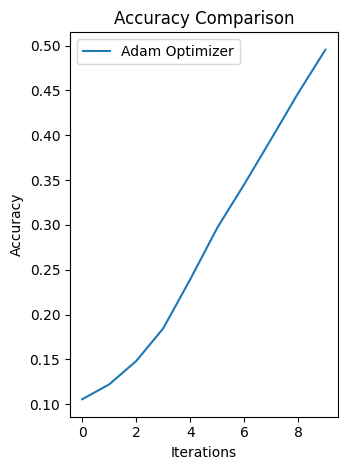

In [17]:
# Graph Accuracy

plt.subplot(1, 2, 2)
plt.plot(accuracies_classical, label='SGD Optimizer')
plt.plot(accuracies_adam, label='Adam Optimizer')
plt.title('Accuracy Comparison')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

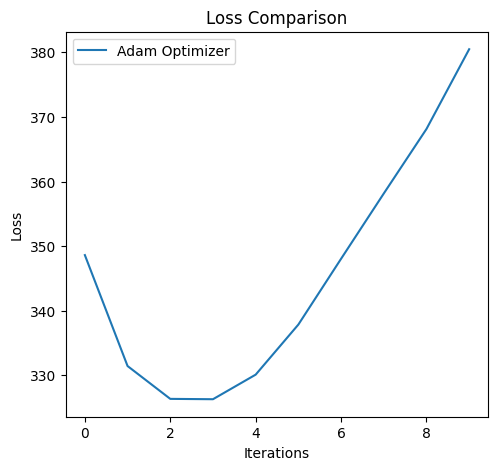

In [18]:
#Graph Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses_classical, label='SGD Optimizer')
plt.plot(losses_adam, label='Adam Optimizer')
plt.title('Loss Comparison')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

### Adam comparison 

In [19]:
#adam
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from keras.optimizers import Adam
# load train and test dataset
def load_dataset():
	(trainX, trainY), (testX, testY) = mnist.load_data()
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

# scale pixels
def prep_pixels(train, test):
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt =Adam(learning_rate=0.001)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=20, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories


trainX, trainY, testX, testY = load_dataset()
trainX, testX = prep_pixels(trainX, testX)
#store data
adam_scores, adam_histories = evaluate_model(trainX, trainY)






> 98.292
> 98.492
> 98.692


KeyboardInterrupt: 

In [51]:
# adagrad
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad
from tensorflow.keras.callbacks import LambdaCallback
# load train and test dataset
def load_dataset():
	(trainX, trainY), (testX, testY) = mnist.load_data()
	# reshape dataset to have a single channel
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY


# scale pixels
def prep_pixels(train, test):
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = tf.keras.optimizers.experimental.Adagrad(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=3):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=20, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories


trainX, trainY, testX, testY = load_dataset()
trainX, testX = prep_pixels(trainX, testX)
# Get result
adagrad_scores, adagrad_histories = evaluate_model(trainX, trainY)



> 96.560
> 96.400
> 96.460


In [ ]:
# adadelta
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad
from tensorflow.keras.callbacks import LambdaCallback
# load train and test dataset
def load_dataset():
	(trainX, trainY), (testX, testY) = mnist.load_data()
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

# scale pixels
def prep_pixels(train, test):
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = tf.keras.optimizers.experimental.Adadelta(learning_rate=0.001) #choose our optimizer here
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=3):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=20, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories



trainX, trainY, testX, testY = load_dataset()
trainX, testX = prep_pixels(trainX, testX)
# Store results
adadelta_scores, adadelta_histories = evaluate_model(trainX, trainY)



In [ ]:
#rms prop
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad
# load train and test dataset
def load_dataset():
	(trainX, trainY), (testX, testY) = mnist.load_data()
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

# scale pixels
def prep_pixels(train, test):
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    opt = RMSprop(learning_rate=0.1)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=3):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=20, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		scores.append(acc)
		histories.append(history)
	return scores, histories

trainX, trainY, testX, testY = load_dataset()
trainX, testX = prep_pixels(trainX, testX)
# stores result
rms_scores, rms_histories = evaluate_model(trainX, trainY)



### Graph 

In [ ]:
import scienceplots
import itertools
plt.style.use(["ieee", "nature", "notebook", "no-latex"])
colors = plt.cm.turbo(np.linspace(0,0.4))

In [ ]:
plt.plot(adam_histories[4].history['val_accuracy'], linestyle="-", markersize=5, color=colors[5])
plt.plot(adagrad_histories[2].history['val_accuracy'], linestyle="-", markersize=5, color=colors[15])
plt.plot(adadelta_histories[2].history['val_accuracy'], linestyle="-", markersize=5, color=colors[25])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Adam', 'Adagrad','Adadelta'], loc='lower right')
plt.grid(True)
plt.show()

plt.plot(adam_histories[4].history['val_loss'], linestyle="-", markersize=5, color=colors[49])
plt.plot(adagrad_histories[2].history['val_loss'], linestyle="-", markersize=5, color=colors[40])
plt.plot(adadelta_histories[2].history['val_loss'], linestyle="-", markersize=5, color=colors[30])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend(['Adam', 'Adagrad','Adadelta'], loc='upper right')
plt.show()